<h1>
<img src="https://www.graphicsprings.com/filestorage/stencils/a430e409239fe7d460e7dcad29afd43e.png"
  width="200"
  height="200">
</h1>
<h2><i>Hybrid Recommender System to Personalized Notification based on User's Recent Search Activity and Behavior</i></h2>

[![Build Status](https://svgshare.com/i/QdF.svg?branch=master)](https://linkedin.com/in/jettlecaros)
<a href='https://ko-fi.com/jettlecaros' target='_blank' title='support: https://ko-fi.com/jettlecaros'>
<img src="https://az743702.vo.msecnd.net/cdn/kofi3.png?v=2" width="90" height="90">
</a>

#### Initialize SPARK Clusters and SparkSQL Magic

In [19]:

import findspark
findspark.init()
findspark.find()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, DataFrame, HiveContext, SQLContext

spark= SparkSession.builder.appName('Ops').getOrCreate()
sc = spark.sparkContext

sqlContext = SQLContext(sc)
hivContext = HiveContext(sc)

#to parelized RDD
#spark.SparkContext.parallelize(data)

#import sys
#!{sys.executable} -m pip install sparksql-magic
#For SQL Magic

%reload_ext sparksql_magic
%config SparkSql.limit=10

#### Initialize Python Libraries

In [40]:
import re
from IPython.display import HTML,display
import datetime as dtz, time, pytz, sys, os
from dateutil.relativedelta import relativedelta

from pyspark.sql.functions import *
from datetime import datetime, timedelta as str_to_timedelta
from pyspark.sql.types import StructType, StructField, BooleanType, IntegerType, DoubleType, StringType, LongType, \
            TimestampType, DateType, FloatType
# spark.conf.set("spark.sql.execution.arrow.fallback.enabled", "true")

from elasticsearch import Elasticsearch
#es = Elasticsearch('http://localhost:9200')
es = Elasticsearch()


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sea
sea.set(style="white",color_codes=True)
import operator, warnings
from pandasticsearch import Select

pd.set_option("display.max_column", 500)
#pd.reset_option('all')


def ldtz(DATETME_FORMAT):
    LOCAL_TZ = pytz.timezone("Asia/Manila")
    DATETIME_UTCNOW = datetime.datetime.utcnow()
    datetime_tz = datetime.datetime.strftime(pytz.utc.localize(DATETIME_UTCNOW).astimezone(LOCAL_TZ), DATETME_FORMAT)
    return datetime_tz

### Set up Database User Credentials

In [21]:
import os
from dotenv import load_dotenv

basedir = os.path.abspath(os.getcwd())
load_dotenv(os.path.join(basedir, '.env'))

#PostgresSQL
databaseName =str(os.environ.get('POSTGRES_DB'))
user=str(os.environ.get('POSTGRES_USER'))
password=str(os.environ.get('POSTGRES_PASSWORD'))
url=f"jdbc:postgresql://localhost:5432/{databaseName}"
driver="org.postgresql.Driver"
properties = {"user": user,"password": password,"driver": driver }

#### Class Method to convert file to Spark Dataframe

In [22]:
class jprofiler:
    def __init__(obj, filename, path):
        obj.sfilename = filename
        obj.spath = path
    
    def CreateCSVPathAndDF(par):
        path_of_file = f"{par.spath}/{par.sfilename}"
        CSVTodataFrame = spark.read.csv(path_of_file, header=True, multiLine=True, escape='\\', quote='"', inferSchema=True, encoding='ISO-8859-1')
        CSVTodataFrame = CSVTodataFrame.toDF(*[re.sub('[\r|\t|\n|,| |]','_',x) for x in CSVTodataFrame.columns])
        return CSVTodataFrame

#### Transform pandas to spark and create temporary table for more analysis

In [23]:
#Convert DF Pandas to DF Spark using Auxiliar functions
def equivalent_type(f):
    if f == 'datetime64[ns]': return DateType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

# Given pandas dataframe, it will return a spark's dataframe.
def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
        struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return spark.createDataFrame(pandas_df, p_schema)


#### Get the file, format, cleaning and transform to dataframe, and SPARK SQL

In [8]:
#DEVELOPMENT USING TEST DATASETS
df_records = jprofiler(filename='datasets.csv', path='/home/jett/Desktop/Notebook/Recommendations/data').CreateCSVPathAndDF()
df_user_accounts = jprofiler('udataset.csv', '/home/jett/Desktop/Notebook/Recommendations/data' ).CreateCSVPathAndDF()
df_smatrix = jprofiler('smatrix.csv', '/home/jett/Desktop/Notebook/Recommendations/data').CreateCSVPathAndDF()
df_cstat = jprofiler('cstat.csv', '/home/jett/Desktop/Notebook/Recommendations/data').CreateCSVPathAndDF()

training_data2 = jprofiler('training_data2.csv', '/home/jett/Desktop/Notebook/Recommendations/data').CreateCSVPathAndDF()


for x in df_smatrix.columns:
    df_smatrix = df_smatrix.withColumn(x, col(x).cast(IntegerType()) )

for x in df_cstat.columns:
    df_cstat = df_cstat.withColumn(x, col(x).cast(IntegerType()) )


df_user_accounts = df_user_accounts.select(
                df_user_accounts['id'].cast(IntegerType()).alias('id'),
                df_user_accounts['username'].alias('name'),
                regexp_replace(df_user_accounts['email'], '[\n|\t|\r]', '').alias('user_name')
)

#df_user_accounts.toPandas()

#Create Tempory View [Development]
df_records.createOrReplaceTempView('records')
df_user_accounts.createOrReplaceTempView('user_accounts')
df_smatrix.createOrReplaceTempView('smatrix')
df_cstat.createOrReplaceTempView('stat')

training_data2.createOrReplaceTempView('training_data2')

print("Successfull Created Dataframes and Temp View")

Successfull Created Dataframes and Temp View


#### [PRODUCTION] Getting the data from Elastic Search, formating, cleaning and transform to dataframe

In [30]:
#[PRODUCTIONS] Get the data from ELasticsearch and convert it to pandas and to SPARK.SQL
import os
# from pyspark.sql import Row
from pyspark.sql.types import Row
from pyspark.sql.functions import col, lit

# set environment variable PYSPARK_SUBMIT_ARGS
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /opt/spark/jars/elasticsearch-hadoop-7.1.1.jar pyspark-shell'


def es_to_df(index):
    conf = {"es.resource" : f"{index}"}   # assume Elasticsearch is running on localhost defaults
    rdd = sc.newAPIHadoopRDD("org.elasticsearch.hadoop.mr.EsInputFormat",\
                             "org.apache.hadoop.io.NullWritable",\
                             "org.elasticsearch.hadoop.mr.LinkedMapWritable",\
                             conf=conf)
    return rdd

# #Get Simple Search Stat Document
rdd = es_to_df(index='stat')
df = rdd.map(lambda p: Row(id=p[0],data=p[1]))
df = spark.createDataFrame(df)
df = df.select(col("data.keyword"), col("data.user").cast(IntegerType()).alias("user"), col("data.timestamp").cast(TimestampType()).alias("timestamp"))
df.createOrReplaceTempView('stat_simple')



#Get Stat Datasets Document
rdd = es_to_df(index='cstat')
df = rdd.map(lambda p: Row(id=p[0], record_id = p[1]['record_id'], user_id = p[1]['user_id'], views = p[1]['views'] , timestamp= p[1]['timestamp'] ))
df = spark.createDataFrame(df)
df = (df.withColumn("record_id", col("record_id").cast(IntegerType()).alias("record_id")).\
      withColumn("user_id", col("user_id").cast(IntegerType()).alias("user_id")).\
      withColumn("views", col("views").cast(IntegerType()).alias("views")).\
      withColumn("timestamp", col("timestamp").cast(TimestampType()).alias("timestamp"))
     )

#df.withColumn("cMap", typedLit(Map.empty[String, String])) 
df.createOrReplaceTempView('stat')


#Get Number of Likes Datasets Document
rdd = es_to_df(index='clikes')
df = rdd.map(lambda p: Row(id=p[0], record_id = p[1]['record_id'], user_id = p[1]['user_id'], likes = p[1]['likes'] , timestamp= p[1]['timestamp'] ))
df = spark.createDataFrame(df)
df = (df.withColumn("record_id", col("record_id").cast(IntegerType()).alias("record_id")).\
      withColumn("user_id", col("user_id").cast(IntegerType()).alias("user_id")).\
      withColumn("likes", col("likes").cast(IntegerType()).alias("views")).\
      withColumn("timestamp", col("timestamp").cast(TimestampType()).alias("timestamp"))
     )
df.createOrReplaceTempView('record_stat_likes')


In [25]:
#User account to DF to SPARKSQL
def postgresql_to_df(tableName):
    df= spark.read \
        .format("jdbc") \
        .option("url", url) \
        .option("dbtable", tableName) \
        .option("user",user ) \
        .option("password",password) \
        .option("driver", driver) \
        .load()
    return df

df = postgresql_to_df("public.user")    
df = df.select( df['id'].cast(IntegerType()).alias('id'),
                df['username'].alias('name'),
                regexp_replace(df['email'], '[\n|\t|\r]', '').alias('user_name')
)
df.createOrReplaceTempView('user_accounts')


df = postgresql_to_df("post")
df.createOrReplaceTempView('records')

df = postgresql_to_df("personalized_notification_info")
df.createOrReplaceTempView('personalized_notification_info')

print("Successfull Created Dataframe and Temp View for user_accounts, personalized_notification_info and records")

Successfull Created Dataframe and Temp View for user_accounts, personalized_notification_info and records


## Module I

#### Content based filtering is based on the meta data available stored in our database.

In [266]:
html1 = """
<!DOCTYPE html>
<meta charset="utf-8">
<style>
.header {
  padding: 20px;
  text-align: center;
  background: #1abc9c;
  color: white;
  font-size: 20px;
}
</style>
<body>
<div class="header">
  <h1>Content-Based Filtering</h1>
  <p><center>Recommender System</center></p>
</div>
</body>
"""
HTML(html1)

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Convert to Pandas
ds = spark.sql("SELECT id, concat_ws(' ', title, community_type, material_publication_type, author_name, body) as description FROM records")
ds = ds.toPandas()

The TF*IDF algorithm is used to weigh a keyword in any document and assign the importance to that keyword based on the number of times it appears in the document. Put simply, the higher the TF*IDF score (weight), the rarer and more important the term, and vice versa.

Each word or term has its respective TF and IDF score. The product of the TF and IDF scores of a term is called the TF*IDF weight of that term.

The TF (term frequency) of a word is the number of times it appears in a document. When you know it, you’re able to see if you’re using a term too often or too infrequently.

``TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).``

The IDF (inverse document frequency) of a word is the measure of how significant that term is in the whole corpus.

``IDF(t) = log_e(Total number of documents / Number of documents with term t in it).``

<img src="https://miro.medium.com/max/364/1*3Ig7VSgscBzXaYa0Q-UM1w.png"
  width="300"
  height="200">

In Python, scikit-learn provides you a pre-built TF-IDF vectorizer that calculates the TF-IDF score for each document’s description, word-by-word.

In [110]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds['description'])

The tfidf_matrix is the matrix containing each word and its TF-IDF score with regard to each document, or item in this case. Also, stop words are simply words that add no significant value to our system, like ‘an’, ‘is’, ‘the’, and hence are ignored by the system.

In [111]:
import uuid
from pyspark.sql.functions import udf
uuidUdf= udf(lambda : str(uuid.uuid4()),StringType())


cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

results = {}

for idx, row in ds.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], ds['id'][i]) for i in similar_indices]
    results[row['id']] = similar_items[1:]
    
#print('Done!')

def item(id):
    return ds.loc[ds['id'] == id]['description'].tolist()[0].split(' - ')[0]

# Just reads the results out of the dictionary.
def recommend(item_id, num):
    #print("Recommending " + str(num) + " products similar to "+ str(item_id) +" with sescriptions " + item(item_id) + "...")
    record_id = str(item_id) 
    #print("-------")
    recs = results[item_id][:num]
    similar_items = []
    for rec in recs:
        #print("Recommended: " + item(rec[1]) + " (score:" + str(rec[0]) + ")")
        similar_items.append(str(rec[1]))
    return similar_items


content_recommend = []
for x in list(ds['id']):
    dx = recommend(item_id=x, num=20)
    content_recommend.append([x, dx])
    
df = pd.DataFrame(content_recommend, columns=["record_id", "recommended_content_id"])
df = df.explode('recommended_content_id')
df = pandas_to_spark(df)
df = df.select(lit(uuidUdf()).alias("uuid"), "*")

# # #TRUNCATE AND LOAD TO POSTGRES
df.write\
    .option("truncate", True)\
    .jdbc(url=url, table="content_recommendation", mode = "overwrite", properties=properties)

## Module II

In [1141]:
displayHTML="""
<!DOCTYPE html>
<meta charset="utf-8">
<style>
.header {
  padding: 20px;
  text-align: center;
  background: #1abc9c;
  color: white;
  font-size: 20px;
}
.header h1{
color:#FFFFFF !important;
}
</style>
<body>
<div class="header">
  <h1>Collaborative Filtering: Popularity and Matrix Factorization</h1>
  <p><center>Recommender System</center></p>

</div>
<div>
  <small><i> Take Note: When receiving Collaborative Recommendation using Popularity Records/Publications (Table1), 
  users should have atleast 1 record stat entry in the database. Otherwise, in table2, 
  record_stat is not required which means, it is based on Hybrid Recommendation System
  wherein Content Filtering, Collaborative Filtering using, Memory based (Cosine similarity, User's Recent search that are similar to items') and Model based (Matrix Factorization) are included in the Model<i></small>
</body>
</div>
"""
HTML(displayHTML)

# First Collaborative Filtering is based on Popularity of records

### Create a Training sets using Spark SQL (Productions STAT)

In [112]:
%%sparksql --cache --view training_dataset df_training_dataset_from_stat -l 5
    SELECT r.user_id, u.user_name, r.record_id as click_article_id, r.views as click_environment ,
        date_format(r.timestamp, 'yyyyMM') as timestamp
    from stat r
    LEFT JOIN user_accounts u
        ON u.id = r.user_id
    WHERE r.views <> 0
        and (user_id IS NOT NULL or name != 'NaN')  
    ;

/*CHECKING VARIABLE*/

cache dataframe with lazy load
create temporary view `training_dataset`
capture dataframe to local variable `df_training_dataset_from_stat`
only showing top 5 row(s)


#### Convert SparkDF to PandasDF and name it DATA 

##### (This will be used in CONTENT RECOMMENDATION 'Popularity Count' and COLLABORATIVE RECOMMENDATION (MATRIX FACTORIZATION))

In [113]:
#Important DF
data = df_training_dataset_from_stat.toPandas()

#### Count number of publication records and columns

In [114]:
product=data['click_article_id'].value_counts()
print("Total Number of Columns : {}".format(data.shape[1]))
print("Total Results : {}".format(data.shape[0]))
print("Total Click Article : {}".format(len(product)))

Total Number of Columns : 5
Total Results : 5373
Total Click Article : 708


#### Create Dataframe with sum of popular publication by behavior

In [115]:
df_product_visualization = data.groupby(by=['click_article_id', 'timestamp'])['click_environment'].sum().sort_values(ascending=False).reset_index()
df_product_visualization.tail(5)

click_article_id timestamp  click_environment
703               334    202103                  3
704                98    202103                  3
705               360    202103                  3
706               525    202103                  2
707               118    202103                  2

### Store to Postgres For Flask Python Report Viewing per day (UI)

In [121]:
#TRUNCATE AND LOAD TO POSTGRES AND STORE IT TO POPULARITY TABLE
df = spark.sql("""
WITH POP_TABLE AS (
    SELECT r.record_id as click_article_id, SUM(r.views) as total_click_environment ,
        cast(date_format(r.timestamp, 'yyyyMMdd') as int) as date
    from stat r
    LEFT JOIN user_accounts u
        ON u.id = r.user_id
    WHERE r.views <> 0 and (user_id IS NOT NULL or name != 'NaN')
    GROUP BY r.record_id, cast(date_format(r.timestamp, 'yyyyMMdd') as int)
) 
SELECT uuid() as uuid, * FROM POP_TABLE
""")

df.write\
    .option("truncate", True)\
    .jdbc(url=url, table="popularity_recommendation", mode = "overwrite", properties=properties)

In [122]:
%%sparksql --cache --view training_sets_test dfTraining_sets -l 5
--THIS WILL BE USE IN VISUALIZATION

WITH S AS (
    SELECT click_article_id, sum(click_environment) as click_environment, timestamp
    FROM training_dataset
    GROUP BY click_article_id, timestamp
)
SELECT * FROM S ORDER BY click_environment DESC LIMIT 15

--THIS WILL BE USE IN VISUALIZATION

cache dataframe with lazy load
create temporary view `training_sets_test`
capture dataframe to local variable `dfTraining_sets`
only showing top 5 row(s)


### Display the most trend Publication

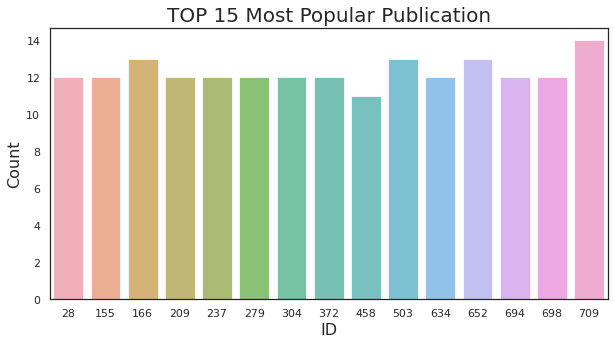

In [123]:
#as_of_timestamp = '202103'
#dfTraining_sets = spark.sql(f"SELECT * FROM training_sets_test where timestamp = '{as_of_timestamp}'")
dfTraining_sets = dfTraining_sets.toDF(*[re.sub('[\r|\n|,|]','_',x) for x in dfTraining_sets.columns])
dfTraining_sets = dfTraining_sets.toPandas()
plt.figure(figsize=(10,5))
sea.barplot(x=dfTraining_sets.click_article_id,\
            y=dfTraining_sets.click_environment,\
            alpha=.75)
plt.title("TOP 15 Most Popular Publication", fontsize=20)
plt.xlabel("ID", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.show();


### Shows Popular Publications/Content in average count 

In [124]:
#client=df_product_visualization.head(5)
plt.figure(figsize=(10,5))
sea.barplot(y=df_product_visualization.click_article_id,\
            x=df_product_visualization.click_environment,\
            palette='OrRd',\
            alpha=.75)
plt.title("Average Click Penetration as of March 2021", fontsize=20)
plt.xlabel("Quantity", fontsize=16)
plt.ylabel("Publication ID", fontsize=16)
plt.show();


### Shows Most active users based on clicking behavior

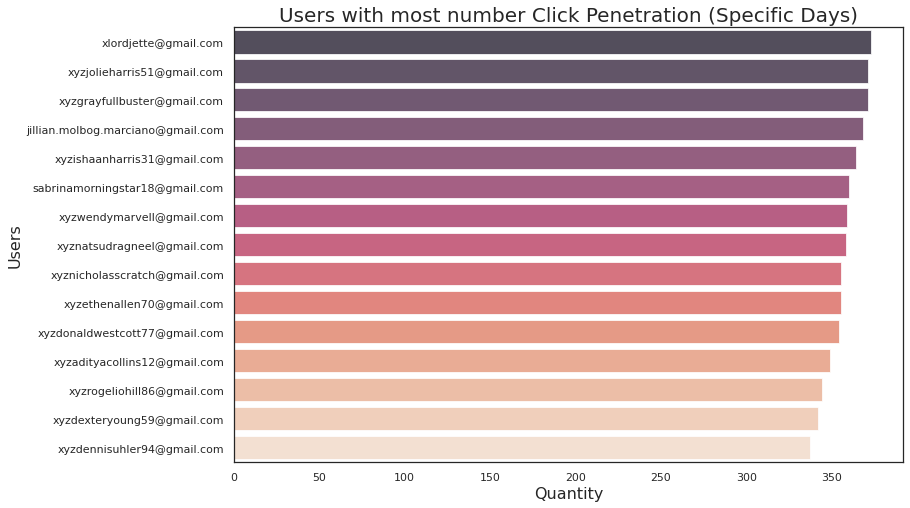

In [125]:
client=data['user_name'].value_counts(sort=True, ascending=False).head(15)
plt.figure(figsize=(12,8))
sea.barplot(y=client.index, x=client.values,palette='rocket', alpha=.75)
plt.title("Users with most number Click Penetration (Specific Days)", fontsize=20)
plt.xlabel("Quantity", fontsize=16)
plt.ylabel("Users", fontsize=16)
plt.show();

### Count number of users involve to each publication and convert to dataframe (Datasets used in Popularity)

In [126]:
#DATASETS NEEDS FOR POPULARITY RECOMMENDATION
df_product_most_popular = data.groupby('click_article_id')['user_id'].count()\
                              .sort_values(ascending=False).reset_index()

#Username is our index
client = data.user_name
client = pd.DataFrame(sorted(set(client)))
print(client.shape)
client.columns = ["username"]
client.head()

(17, 1)


username
0                  dev01@yopmail.com
1  jillian.molbog.marciano@gmail.com
2     sabrinamorningstar18@gmail.com
3               xlordjette@gmail.com
4       xyzadityacollins12@gmail.com

In [127]:
##this is model for popularity
class RecommendationPopular(object):
    PRODUCT_NAME = 'Popular'
    
    def __init__(self, df_popular):
        self.df_popular = df_popular
        
    def get_model_name(self):
        return self.PRODUCT_NAME
        
    def recommender_products(self, products_to_ignore=[], products_to_rec=[], topn=20):
        if len(products_to_rec) == 0:
            df_recommendations = self.df_popular[~self.df_popular['click_article_id'].isin(products_to_ignore)] \
                                 .sort_values('user_id', ascending = False) \
                                 .head(topn)
        else:
            df_recommendations = self.df_popular[self.df_popular['click_article_id'].isin(products_to_rec)] \
                                 .sort_values('user_id', ascending = False) \
                                 .head(topn)
        return df_recommendations

### To recommend the most popular Publication or record's popularity, we could just select the first 15 of the previous analysis and indicate for each Users, further below the formula for a recommendation.

In [128]:
popular_model = RecommendationPopular(df_product_most_popular)
pop_recommender = popular_model.recommender_products()

name = []
product_recommend = []
table = [name, product_recommend]
for i in client.username:
    for j in pop_recommender.click_article_id:
        name.append(i)
        product_recommend.append(j)

### Table1 is the Output of Recommended Record Based on Popularity or number of click per record_id or publication_id

In [129]:
table = pd.DataFrame(table)
table = table.transpose()
table.columns = ["user_name",'recommended site']
table.head()

#Converstion from pandas to spark df using functions
spark_df = pandas_to_spark(table)
spark_df.createOrReplaceTempView('table')

#table[table['user_name']=='jillian.molbog.marciano@gmail.com']

# Second is Hybrid Recommendation using Content Filtering, Collaborative Filtering using Popularity and Matrix Factorization

In [130]:
###Get the dataset
data = data.drop_duplicates(subset=['user_id', 'click_article_id'])
display(data)

user_id                    user_name  click_article_id  \
0          12   xyznatsudragneel@gmail.com                 8   
1          12   xyznatsudragneel@gmail.com                 9   
2          12   xyznatsudragneel@gmail.com                10   
3          12   xyznatsudragneel@gmail.com                15   
4          12   xyznatsudragneel@gmail.com                21   
...       ...                          ...               ...   
5368        2  xyzgrayfullbuster@gmail.com               696   
5369        2  xyzgrayfullbuster@gmail.com               699   
5370        2  xyzgrayfullbuster@gmail.com               701   
5371        2  xyzgrayfullbuster@gmail.com               705   
5372        2  xyzgrayfullbuster@gmail.com               706   

      click_environment timestamp  
0                     1    202103  
1                     1    202103  
2                     1    202103  
3                     1    202103  
4                     1    202103  
...                 ...       ...  
5368                  1    202103  
5369                  1    202103  
5370                  1    202103  
5371                  1    202103  
5372                  1    202103  

[5360 rows x 5 columns]

In [131]:
# Raise a table where the users will be as lines and the products will be as columns, and convert it to float
df_client_products = data.reset_index().pivot(index='user_name', columns='click_article_id', values='click_environment').fillna(0).astype(float)

# Count rows and columns
df_client_products.shape

(17, 708)

In [132]:
# Check the data
df_client_products.head()

click_article_id                   1    2    3    4    5    6    7    8    \
user_name                                                                   
dev01@yopmail.com                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
jillian.molbog.marciano@gmail.com  0.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0   
sabrinamorningstar18@gmail.com     0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0   
xlordjette@gmail.com               0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0   
xyzadityacollins12@gmail.com       0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0   

click_article_id                   9    10   11   12   13   14   15   16   \
user_name                                                                   
dev01@yopmail.com                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
jillian.molbog.marciano@gmail.com  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
sabrinamorningstar18@gmail.com     1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
xlordjette@gmail.com               0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0   
xyzadityacollins12@gmail.com       1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0   

click_article_id                   17   18   19   20   21   22   23   24   \
user_name                                                                   
dev01@yopmail.com                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
jillian.molbog.marciano@gmail.com  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0   
sabrinamorningstar18@gmail.com     0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
xlordjette@gmail.com               0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0   
xyzadityacollins12@gmail.com       1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   

click_article_id                   25   26   27   28   29   30   31   32   \
user_name                                                                   
dev01@yopmail.com                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
jillian.molbog.marciano@gmail.com  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   
sabrinamorningstar18@gmail.com     1.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0   
xlordjette@gmail.com               0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0   
xyzadityacollins12@gmail.com       0.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0   

click_article_id                   33   34   35   36   37   38   39   40   \
user_name                                                                   
dev01@yopmail.com                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
jillian.molbog.marciano@gmail.com  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
sabrinamorningstar18@gmail.com     0.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0   
xlordjette@gmail.com               1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0   
xyzadityacollins12@gmail.com       1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0   

click_article_id                   41   42   43   44   45   46   47   48   \
user_name                                                                   
dev01@yopmail.com                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
jillian.molbog.marciano@gmail.com  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0   
sabrinamorningstar18@gmail.com     1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0   
xlordjette@gmail.com               0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0   
xyzadityacollins12@gmail.com       1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0   

click_article_id                   49   50   51   52   53   54   55   56   \
user_name                                                                   
dev01@yopmail.com                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
jillian.molbog.marciano@gmail.com  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
sabrinamorningstar18@gmail.com     1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
xlordjette@gmail.com               0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0   
xyzadityacollins12@gmail.com       1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0   

click_article_id                   57   58   59   60   61   62   63   64   \
user_name                                                                   
dev01@yopmail.com                  0.0  0.0  0.0  0.0  0.0  0.0  0

In [133]:
# Transform dataframe to Matrix
df_client_product_matrix = df_client_products.values

# Attributing or indexing to client_ids
client_ids= df_client_products.index.tolist()

# Print first five in matrix
df_client_product_matrix[:5]

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 1., 0.]])

### SVDS Model

In [134]:
from scipy.sparse.linalg import svds

# Execute Matrix Factorization
# k = 6, number of Factors/Vectors that we are going to obtain

U, sigma, Vt = svds(df_client_product_matrix, k = 6)
sigma = np.diag(sigma)

print(U.shape)
print(sigma.shape)
print(Vt.shape)

# Rebuilding the matrix
all_clients_predict = np.dot(np.dot(U, sigma), Vt) 

#Converting a reconstructed matrix in DataFrame
df_cf_preds = pd.DataFrame(all_clients_predict, 
                           columns = df_client_products.columns, 
                           index=client_ids).transpose()
df_cf_preds.head()

(17, 6)
(6, 6)
(6, 708)


dev01@yopmail.com  jillian.molbog.marciano@gmail.com  \
click_article_id                                                         
1                          0.001129                           0.375117   
2                         -0.004678                           0.634227   
3                          0.000993                           0.515398   
4                          0.005435                           0.326195   
5                          0.004242                           0.310836   

                  sabrinamorningstar18@gmail.com  xlordjette@gmail.com  \
click_article_id                                                         
1                                       0.193813              0.406373   
2                                       0.410102              0.236506   
3                                       0.352069              0.775420   
4                                       0.477551              0.846820   
5                                       0.850975              0.036275   

                  xyzadityacollins12@gmail.com  xyzdennisuhler94@gmail.com  \
click_article_id                                                             
1                                     0.251094                    0.465251   
2                                     0.234826                    0.125422   
3                                     0.624964                    0.143019   
4                                     0.691142                    0.209394   
5                                     0.022844                    0.687251   

                  xyzdexteryoung59@gmail.com  xyzdonaldwestcott77@gmail.com  \
click_article_id                                                              
1                                   0.241969                       0.294260   
2                                   0.478121                       0.842787   
3                                   0.588943                       0.801118   
4                                   0.347016                       0.538302   
5                                  -0.358484                       0.003817   

                  xyzethenallen70@gmail.com  xyzgrayfullbuster@gmail.com  \
click_article_id                                                           
1                                  0.382700                     0.981601   
2                                  0.671533                     0.222884   
3                                  0.502226                     0.458222   
4                                  0.378190                     0.327194   
5                                  0.546747                     0.463341   

                  xyzishaanharris31@gmail.com  xyzjolieharris51@gmail.com  \
click_article_id                                                            
1                                    1.034308                    0.183105   
2                                   -0.018402                    0.046278   
3                                    0.739323                    0.501693   
4                                    0.953407                    0.765548   
5                                    0.753570                    0.412868   

                  xyznatsudragneel@gmail.com  xyznicholasscratch@gmail.com  \
click_article_id                                                             
1                                   0.168798                      0.693437   
2                                   0.414358                      0.477294   
3                                   0.401843                      0.559804   
4                                   0.362965                      0.317836   
5                                   0.323412                      0.168707   

                  xyzpundato@yahoo.com  xyzrogeliohill86@gmail.com  \
click_article_id                                                     
1                             0.008018                    0.622027   
2                             0.013818           

In [135]:
class CFRecomendador:
    MODEL_NAME = 'Colaborative Filter'
    def __init__(self, product_model, df_cf_predicts):
        self.product_model = product_model
        self.df_cf_predicts = df_cf_predicts
    
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommender_products(self, client_id, products_to_ignore=[], products_to_rec=[], topn=20):
        if client_id in df_cf_preds.columns:   
            clients_predict = self.df_cf_predicts[client_id].reset_index().rename(columns={client_id: 'quantidade'})
            if len(products_to_rec) == 0:
                
                df_recommendations = clients_predict[~clients_predict['click_article_id'].isin(products_to_ignore)] \
                                     .drop_duplicates(subset=['click_article_id'])\
                                     .sort_values('quantidade', ascending = False) \
                                     .head(topn)
            else:
                df_recommendations = clients_predict[clients_predict['click_article_id'].isin(products_to_rec)] \
                                     .drop_duplicates(subset=['click_article_id'])\
                                     .sort_values('quantidade', ascending = False) \
                                     .head(topn)                
        else:
            df_recommendations = self.product_model.recommender_products(products_to_ignore, products_to_rec, topn)
        return df_recommendations


In [136]:
#Train the Datasets
popular_model = RecommendationPopular(df_product_most_popular)
cfr_model = CFRecomendador(popular_model, df_cf_preds)

# cfr_recommend = cfr_model.recommender_products('xlordjette@gmail.com')
# #Default is Top 20
# cfr_recommend.head()

### <i>Table 2</i> is made up of Collaborative Filtering using Model Based (Matrix Factorization). This will be use to create the first part of Hybrid Recommendation System.

In [137]:
user_accounts = spark.sql("SELECT DISTINCT user_name as username FROM user_accounts").toPandas()
personalized_notification_info = spark.sql("SELECT * FROM personalized_notification_info").toPandas()

name2 = []
products2_recommend = []
table2 = [name2, products2_recommend]
for i in user_accounts.username: #client.username.drop_duplicates():
    cfr_recommend = cfr_model.recommender_products(i)
    for j in cfr_recommend.click_article_id:
        name2.append(i)
        products2_recommend.append(j)
        
        
table2 = pd.DataFrame(table2)
table2 = table2.transpose()
table2.columns = ["user_name",'recommended_code']

#Convert Pandas to Pyspark SQL
spark_df = pandas_to_spark(table2)
spark_df.createOrReplaceTempView('table2')

### <i>Recomendation_table_based_on_search</i> table another type of Collaborative Filtering using Memory Based (Cosine Similarities of User to Item). This will be added as second part of Hybrid Recommendation System.

In [138]:
###Content based Recommender using search silimilar items 
ds = spark.sql("""
WITH get_top_10_latest_stat_simple AS (
    SELECT user, keyword, row_number() over(partition by user order by timestamp desc) as rn
    FROM stat_simple
    WHERE regexp_replace(keyword, '(\\d+)', 'num')  <> 'num' and length(keyword) > 2
)

, string_stat_simple AS (
    SELECT  user as id, collect_list(keyword) as collect_list_keyword 
     FROM get_top_10_latest_stat_simple
    WHERE rn <=10
    GROUP BY user
)
SELECT id, regexp_replace(cast(collect_list_keyword as string), '[\\\[\\\]]', '') as descriptions FROM string_stat_simple
""").toPandas()

record_ds = spark.sql("""SELECT id, concat_ws('', id, '|', title) as descriptions FROM records""").toPandas()

corpus = ds['descriptions']
test = record_ds['descriptions']

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel 

tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')
tfidf_matrix =  tf.fit_transform(corpus)
tfidf_matrix2 =  tf.transform(test)


def new_find_similar(tfidf_matrix2, index, tfidf_matrix, top_n = 10):
    cosine_similarities = linear_kernel(tfidf_matrix2[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]


content_recommend_search = []
for c in range(len(ds['id'])):
    for index, score in new_find_similar(tfidf_matrix, c,  tfidf_matrix2):
        record_idx = test[index].split('|')[0]
        content_recommend_search.append([ds.id[c], record_idx])

df = pd.DataFrame(content_recommend_search, columns=["user_id", "recommended_content_filtered_id"])
df = pandas_to_spark(df)
df.createOrReplaceTempView("Recomendation_table_based_on_search")

### <i>Check the sent recommendation to filter only the unsent recommender data</i>

In [427]:
## Get the SMTP Logs first in Postgres
## This is required to check if records has been already sent or recommended among usersa
import time
st = time.time()
df_smtplogs_psql= spark.read \
    .format("jdbc") \
    .option("url", url) \
    .option("dbtable", "smtp_logs") \
    .option("user",user ) \
    .option("password",password) \
    .option("driver", driver) \
    .load()

df_smtplogs_psql.createOrReplaceTempView("tbl_smtplogs_psql")
df_smtplogs_psql_to_vlookid = df_smtplogs_psql["user_id", "rcode"].distinct()
print(f"total time: {end-st}")

total time: -435.9296917915344


## tbl_recommendation includes the Personalized Recommendation of Users in Hybrid Recommender System. In short this is the final output of Recommender System

In [428]:
%%sparksql --cache --view tbl_recommendation df_recommendation  -l 1
--BASED ON COLLABORATIVE FILTERING USING MATRIX FACTORIZATION AND POPULARITY MODEL
WITH recommender_engine_io AS (
    SELECT DISTINCT b.id as user_id, b.name as name,
        a.user_name as email, a.recommended_code,
        c.title,
        c.community_type, c.material_publication_type,
        c.author_name, 
        CASE WHEN c.body IS NULL or c.body = '' or c.body=' ' THEN ''
             ELSE concat(left(c.body, 300), '...')
        END as body,
        c.access_right, date_format(timestamp, 'MMMM dd, yyyy') as timestamp,
        b.user_name,
        --'cfmatrix' as type,
        row_number() over(partition by b.id order by rand()) as ran
    from table2 a
    INNER JOIN user_accounts b
      ON a.user_name = b.user_name
    INNER JOIN records c
      ON a.recommended_code = c.ID
    WHERE concat(b.id, 'X', a.recommended_code) NOT IN (SELECT concat(user_id, 'X', rcode) as vlookid FROM tbl_smtplogs_psql)
    
    
    UNION
    
    SELECT DISTINCT b.id as user_id, b.name as name,
        b.user_name as email, a.recommended_content_filtered_id as recommended_code,
        c.title,
        c.community_type, c.material_publication_type,
        c.author_name, 
        CASE WHEN c.body IS NULL or c.body = '' or c.body=' ' THEN ''
             ELSE concat(left(c.body, 300), '...')
        END as body,
        c.access_right, date_format(timestamp, 'MMMM dd, yyyy') as timestamp,
        b.user_name,
        --'cfcosine' as type,
        row_number() over(partition by b.id order by rand()) as ran
    from Recomendation_table_based_on_search a
    INNER JOIN user_accounts b
      ON a.user_id = b.id
    INNER JOIN records c
      ON a.recommended_content_filtered_id = c.ID
    WHERE concat(a.user_id, 'X', a.recommended_content_filtered_id ) NOT IN (SELECT concat(user_id, 'X', rcode) as vlookid FROM tbl_smtplogs_psql)
      
)
, user_notification_settings_exploded AS (
    SELECT DISTINCT 
        explode(community_type) as lookup_community_type, 
        material_publication_type as lookup_material_publication_type,
        activate_pn, user_id as lookup_user_id
    from personalized_notification_info
    WHERE activate_pn = 'y'
)

, personalized_recommendations AS (
    
SELECT DISTINCT a.*
    from recommender_engine_io a
INNER JOIN user_notification_settings_exploded b
    ON a.user_id = b.lookup_user_id
    and (
        (array_contains(a.community_type, b.lookup_community_type) = True and a.material_publication_type = b.lookup_material_publication_type)
        or
        (array_contains(a.community_type, b.lookup_community_type) = True and b.lookup_material_publication_type = 'all')
        or
        (b.lookup_community_type = 'all' and a.material_publication_type = b.lookup_material_publication_type)
        or
        (b.lookup_community_type = 'all' and b.lookup_material_publication_type = 'all')
    )
)


SELECT *  FROM personalized_recommendations WHERE ran <=4


--ORDER BY rand()
--jillian.molbog.marciano@gmail.com

cache dataframe with lazy load
create temporary view `tbl_recommendation`
capture dataframe to local variable `df_recommendation`
only showing top 1 row(s)


In [1139]:
HTML("""
<!DOCTYPE html>
<meta charset="utf-8">
<style>
.header {
  padding: 15px;
  text-align: center;
  background: #1abc9c;
  color: #FFFFFF;
  font-size: 20px;
}
.header h1{
color:#FFFFFF !important;
}
</style>
<body>
<div class="header">
  <h1>SMTP Email Notification</h1>
  <p><center>Recommender System</center></p>
</div>
</body>
""")

### HEAD of HTML version

In [407]:
def getHEADfunction():
    head= """

    <!DOCTYPE html>
    <html lang="en" xmlns="http://www.w3.org/1999/xhtml" xmlns:v="urn:schemas-microsoft-com:vml" xmlns:o="urn:schemas-microsoft-com:office:office">

    <head>
        <meta charset="utf-8">
        <!-- utf-8 works for most cases -->
        <meta name="viewport" content="width=device-width">
        <!-- Forcing initial-scale shouldn't be necessary -->
        <meta http-equiv="X-UA-Compatible" content="IE=edge">
        <!-- Use the latest (edge) version of IE rendering engine -->
        <meta name="x-apple-disable-message-reformatting">
        <!-- Disable auto-scale in iOS 10 Mail entirely -->
        <title></title>
        <!-- The title tag shows in email notifications, like Android 4.4. -->

        <!--<link href="https://fonts.googleapis.com/css?family=Work+Sans:200,300,400,500,600,700" rel="stylesheet">-->

        <link rel="preconnect" href="https://fonts.gstatic.com">
        <link href="https://fonts.googleapis.com/css2?family=Roboto:wght@300&display=swap" rel="stylesheet">

        <!-- CSS Reset : BEGIN -->
        <style>
            /* What it does: Remove spaces around the email design added by some email clients. */
            /* Beware: It can remove the padding / margin and add a background color to the compose a reply window. */

            html,
            body {
                margin: 0 auto !important;
                padding: 0 !important;
                height: 100% !important;
                width: 100% !important;
                background: #f1f1f1;
            }
            /* What it does: Stops email clients resizing small text. */

            * {
                -ms-text-size-adjust: 100%;
                -webkit-text-size-adjust: 100%;
            }
            /* What it does: Centers email on Android 4.4 */

            div[style*="margin: 15px 0"] {
                margin: 0 !important;
            }
            /* What it does: Stops Outlook from adding extra spacing to tables. */

            table,
            td {
                mso-table-lspace: 0pt !important;
                mso-table-rspace: 0pt !important;
            }
            /* What it does: Fixes webkit padding issue. */

            small.warning {
                color: rgb(255, 165, 0);
                font-weight: 500;
            }

            small.success {
                color: green;
                font-weight: 500;
            }

            small.fail {
                color: orangered;
                font-weight: 500;
            }

            small.author_name{
                color:black;
                float:left;
                margin:10px 0 10px 0;

            }

            table {
                border-spacing: 0 !important;
                border-collapse: collapse !important;
                table-layout: fixed !important;
                margin: 0 auto !important;
            }

            /* What it does: Uses a better rendering method when resizing images in IE. */

            tr:hover, td {

            background-color: #FFFFFF;


            }

            img {
                -ms-interpolation-mode: bicubic;
            }
            /* What it does: Prevents Windows 10 Mail from underlining links despite inline CSS. Styles for underlined links should be inline. */

            a {
                text-decoration: none;
            }
            /* What it does: A work-around for email clients meddling in triggered links. */

            *[x-apple-data-detectors],
            /* iOS */

            .unstyle-auto-detected-links *,
            .aBn {
                border-bottom: 0 !important;
                cursor: default !important;
                color: inherit !important;
                text-decoration: none !important;
                font-size: inherit !important;
                font-family: inherit !important;
                font-weight: inherit !important;
                line-height: inherit !important;
            }
            /* What it does: Prevents Gmail from displaying a download button on large, non-linked images. */

            .a6S {
                display: none !important;
                opacity: 0.01 !important;
            }
            /* What it does: Prevents Gmail from changing the text color in conversation threads. */

            .im {
                color: inherit !important;
            }
            /* If the above doesn't work, add a .g-img class to any image in question. */

            img.g-img+div {
                display: none !important;
            }
            /* What it does: Removes right gutter in Gmail iOS app: https://github.com/TedGoas/Cerberus/issues/89  */
            /* Create one of these media queries for each additional viewport size you'd like to fix */
            /* iPhone 4, 4S, 5, 5S, 5C, and 5SE */

            @media only screen and (min-device-width: 320px) and (max-device-width: 374px) {
                u~div .email-container {
                    min-width: 320px !important;
                }
            }
            /* iPhone 6, 6S, 7, 8, and X */

            @media only screen and (min-device-width: 375px) and (max-device-width: 413px) {
                u~div .email-container {
                    min-width: 375px !important;
                }
            }
            /* iPhone 6+, 7+, and 8+ */

            @media only screen and (min-device-width: 414px) {
                u~div .email-container {
                    min-width: 414px !important;
                }
            }
        </style>

        <!-- CSS Reset : END -->

        <!-- Progressive Enhancements : BEGIN -->
        <style>
            .primary {
                background: #17bebb;
            }

            .bg_white {
                background: #ffffff;
            }

            .bg_light {
                background: #f7fafa;
            }

            .bg_black {
                background: #000000;
            }

            .bg_dark {
                background: rgba(0, 0, 0, .8);
            }

            .email-section {
                padding: 2.5em;
            }
            /*BUTTON*/

            .btn {
                padding: 10px 15px;
                display: inline-block;
            }

            .btn.btn-primary {
                border-radius: 5px;
                background: #17bebb;
                color: #ffffff;
            }

            .btn.btn-white {
                border-radius: 5px;
                background: #ffffff;
                color: #000000;
            }

            .btn.btn-white-outline {
                border-radius: 5px;
                background: transparent;
                border: 1px solid #fff;
                color: #fff;
            }

            .btn.btn-black-outline {
                border-radius: 0px;
                background: transparent;
                border: 2px solid #000;
                color: #000;
                font-weight: 700;
            }

            .btn-custom {
                color: rgba(0, 0, 0, .3);
                text-decoration: underline;
            }

            h1,
            h2,
            h3,
            h4,
            h5,
            h6 {
                /*font-family: 'Work Sans', sans-serif;*/
                font-family: 'Roboto', sans-serif;
                color: #000000;
                margin-top: 0;
                font-weight: 400;
            }

            body {
                font-family: 'Work Sans', sans-serif;
                font-weight: 400;
                font-size: 15px;
                line-height: 1.8;
                color: rgba(0, 0, 0, .4);
            }

            a {
                color: #17bebb;
            }

            table {}
            /*LOGO*/

            .logo h1 {
                margin: 0;
            }

            .logo h1 a {
                color: #17bebb;
                font-size: 24px;
                font-weight: 700;
                font-family: 'Work Sans', sans-serif;
            }
            /*HERO*/

            .hero {
                position: relative;
                z-index: 0;
            }

            .hero .text {
                color: rgba(0, 0, 0, .3);
            }

            .hero .text h2 {
                color: #000;
                font-size: 34px;
                margin-bottom: 15px;
                font-weight: 300;
                line-height: 1.2;
            }

            .hero .text h3 {
                font-size: 24px;
                font-weight: 200;
            }

            .hero .text h2 span {
                font-weight: 600;
                color: #000;
            }
            /*PRODUCT*/

            .product-entry {
                display: block;
                position: relative;
                float: left;
                padding-top: 15px;
            }

            .product-entry .text {
                width: calc(100% - 125px);
                padding-left: 20px;
            }

            .product-entry .text h3 {
                margin-bottom: 0;
                padding-bottom: 0;
            }

            .product-entry .text p {
                margin-top: 0;
            }

            .product-entry img,
            .product-entry .text {
                float: left;
            }

            ul.social {
                padding: 0;
            }

            ul.social li {
                display: inline-block;
                margin-right: 10px;
            }
            /*FOOTER*/

            .footer {
                border-top: 1px solid rgba(0, 0, 0, .05);
                color: rgba(0, 0, 0, .5);
            }

            .footer .heading {
                color: #000;
                font-size: 20px;
            }

            .footer ul {
                margin: 0;
                padding: 0;
            }

            .footer ul li {
                list-style: none;
                margin-bottom: 10px;
            }

            .footer ul li a {
                color: rgba(0, 0, 0, 1);
            }

            @media screen and (max-width: 600px) {}
        </style>
    </head>
    """
    return head

### Full Body HTML

In [408]:
# Create the plain-text and HTML version of your message

def getHTMLfunction(unsubscribe_here_link, head, pd_recommendation_table_tr_tr_final):
    html= f"""
    {head}
    <body width="100%" style="margin: 0; padding: 0 !important; mso-line-height-rule: exactly; background-color: #f1f1f1;">
        <center style="width: 100%; background-color: #f1f1f1;">
            <div style="display: none; font-size: 1px;max-height: 0px; max-width: 0px; opacity: 0; overflow: hidden; mso-hide: all; font-family: sans-serif;">
                &zwnj;&nbsp;&zwnj;&nbsp;&zwnj;&nbsp;&zwnj;&nbsp;&zwnj;&nbsp;&zwnj;&nbsp;&zwnj;&nbsp;&zwnj;&nbsp;&zwnj;
                &nbsp;&zwnj;&nbsp;&zwnj;&nbsp;&zwnj;&nbsp;&zwnj;&nbsp;&zwnj;&nbsp;&zwnj;&nbsp;&zwnj;&nbsp;&zwnj;&nbsp;&zwnj;&nbsp;
            </div>
            <div style="max-width: 800px; margin: 0 auto; " class="email-container">
                <!-- BEGIN BODY -->
                <table align="center" role="presentation" cellspacing="0" cellpadding="0" border="0" width="100%" style="margin: auto;">
                    <tr>
                        <td valign="top" class="bg_white" style="padding: 1em 2.5em 0 2.5em;">
                            <table role="presentation" border="0" cellpadding="0" cellspacing="0" width="100%">
                                <tr>
                                    <td class="logo" style="text-align: left; ">
                                        <!-- <h1><a href="#">Sarai.ph</a></h1> -->
                                        <img src="https://sarai.ph/header_green.png" alt="" style="width: 100%; max-width: 400px; height: auto; margin-bottom: 20px; display: block;">

                                    </td>
                                </tr>
                            </table>
                        </td>
                    </tr>
                    <!-- end tr -->

                    {pd_recommendation_table_tr_tr_final}

                    <!-- end tr -->
                    <!-- 1 Column Text + Button : END -->
                </table>
                <table align="center" role="presentation" cellspacing="0" cellpadding="0" border="0" width="100%" style="margin: auto;">
                    <tr>
                        <td valign="middle" class="bg_light footer email-section">
                            <table>
                                <tr>
                                    <td valign="top" width="33.333%" style="padding-top: 20px;">
                                        <table role="presentation" cellspacing="0" cellpadding="0" border="0" width="100%">
                                            <tr>
                                                <td style="text-align: left; padding-right: 10px;">
                                                    <h3 class="heading">About</h3>
                                                    <p>Project SARAi aims to develop a national crop forecasting and monitoring system for nine priority crops: rice, corn, banana, coconut, coffee, cacao, sugarcane, tomato, and soybean. This project is funded
                                                        by DOST-PCAARRD.
                                                    </p>
                                                </td>
                                            </tr>
                                        </table>
                                    </td>
                                    <td valign="top" width="33.333%" style="padding-top: 20px;">
                                        <table role="presentation" cellspacing="0" cellpadding="0" border="0" width="100%">
                                            <tr>
                                                <td style="text-align: left; padding-left: 5px; padding-right: 5px;">
                                                    <h3 class="heading">Contact Info</h3>
                                                    <ul>
                                                        <li><span class="text">SESAM UPLB, College, Laguna, Philippines 4031</span></li>
                                                        <li><span class="text">+63 (049) 536 2302 +63 (049) 536 2836</span></a>
                                                        </li>
                                                    </ul>
                                                </td>
                                            </tr>
                                        </table>
                                    </td>
                                    <td valign="top" width="33.333%" style="padding-top: 20px;">
                                        <table role="presentation" cellspacing="0" cellpadding="0" border="0" width="100%">
                                            <tr>
                                                <td style="text-align: left; padding-left: 10px;">
                                                    <h3 class="heading">Useful Links</h3>
                                                    <ul>
                                                        <li><a href="https://sarai.ph">Home</a></li>
                                                        <li><a href="http://202.92.144.48/">Sarai Community</a></li>
                                                        <li><a href="http://139.59.125.198/suitability-maps">Interactive Maps</a></li>
                                                        <li><a href="https://sarai.ph/heat-map-rainfall-outlook">Rainfall Outlook</a></li>
                                                        <li><a href="https://sarai.ph/drought">Drought Forecast</a></li>
                                                        <li><a href="https://sarai.ph/weather-monitoring">Weather Monitoring</a></li>
                                                        <li><a href="https://aldrinjao.github.io/soilsmap/">Soil Characteristics</a></li>
                                                    </ul>
                                                </td>
                                            </tr>
                                        </table>
                                    </td>
                                </tr>
                            </table>
                        </td>
                    </tr>
                    <!-- end: tr -->

                    <tr>
                        <td class="bg_white" style="text-align: center;">
                            <p>No longer want to receive these email? You can <a href="{unsubscribe_here_link}" style="color: rgba(0,0,0,.8);">Unsubscribe here</a></p>
                        </td>
                    </tr>
                </table>

            </div>
        </center>
    </body>

    </html>

    """
    return html

### SMTP Sendmail Loop

In [429]:
import time
import datetime as dtz, pytz
from pyspark.sql.functions import udf
from pyspark.sql import Row
import uuid

#Send email with/without Attachement
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
import os.path


st = time.time()
uuidUdf= udf(lambda : str(uuid.uuid4()),StringType())


def ldtz(DATETME_FORMAT):
    LOCAL_TZ = pytz.timezone("Asia/Manila")
    DATETIME_UTCNOW = dtz.datetime.utcnow()
    datetime_tz = dtz.datetime.strftime(pytz.utc.localize(DATETIME_UTCNOW).astimezone(LOCAL_TZ), DATETME_FORMAT)
    return datetime_tz

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

    
def send_email(email_recipient, email_subject,  html, text='', attachment_location = ''):
    email_sender = 'noreply@gmail.com.ph'

    msg = MIMEMultipart()
    msg['From'] = email_sender
    msg['To'] = ", ".join(email_recipient)
    msg['Subject'] = email_subject
    
    #msg.attach(MIMEText(text, 'plain'))
    msg.attach(MIMEText(html, 'html'))
  
  
    if attachment_location != '':
        filename = os.path.basename(attachment_location)
        attachment = open(attachment_location, "rb")
        part = MIMEBase('application', 'octet-stream')
        part.set_payload(attachment.read())
        encoders.encode_base64(part)
        part.add_header('Content-Disposition', "attachment; filename= %s" % filename)
        msg.attach(part)
    
    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.ehlo()
        server.starttls()
        server.login('xyzwalkeryoung38@gmail.com', 'wvxeguhsvpivowkt')

        text = msg.as_string()
        server.sendmail(email_sender, email_recipient, text)
        print('email sent')
        server.quit()
    except:
          print("SMPT server connection error")
    return True



#Convert Spark to Pandas to get only the unsent recommendation.
pd_smtplogs_psql_filtered = df_smtplogs_psql_to_vlookid.toPandas()
#pd_smtplogs_psql_filtered = pd_smtplogs_psql_filtered[pd_smtplogs_psql_filtered.user_id ==int(pd_user_id)]
pd_smtplogs_psql_filtered['vlookid'] = pd_smtplogs_psql_filtered[['user_id','rcode']].apply(lambda x: 'X'.join(map(str, x)), axis=1)
pd_smtplogs_psql_subx = np.unique(pd_smtplogs_psql_filtered['vlookid'])


#Remove the sent recommendation by filtering the datasets where not in pd_smtplogs
pd_recommendation = df_recommendation.toPandas()
pd_recommendation['vlookid_pd'] = pd_recommendation[['user_id','recommended_code']].apply(lambda x: 'X'.join(map(str, x)), axis=1)
pd_recommendation = pd_recommendation[(~pd_recommendation.vlookid_pd.isin(pd_smtplogs_psql_subx))]


pd_users = pd_recommendation[['user_id', 'name', 'email']].drop_duplicates()
pd_users= pd_users.reset_index()[['user_id', 'name', 'email']]

body_hello="Amazing publications, book, serials, feeds, interesting paper right in your inbox."
btn_content_view_more_recom = "View more recommendations"
website_link_view="localhost"

pd_recommendation_table_tr_tr = []
tpendSMTPlogs=[]

for s in range(len(pd_users.user_id)):
    pd_user_id = pd_users.user_id[s]
    pd_name    = pd_users.name[s]
    pd_email   = pd_users.email[s]
    
    heading_hello = f"Hello {pd_name.title()}, here are your personalized recommendations."
    
    #Get the dataset
    pd_recommendation_sub = pd_recommendation[(pd_recommendation["user_id"]==pd_user_id)].reset_index()
    pd_recommendation_table_data = []
    tpend= []
    
    for b in range(len(pd_recommendation_sub['user_id'])):
        snapshot                     = ldtz("%Y-%m-%d %H:%M:%S")
        pd_user_id_matx              = pd_recommendation_sub.user_id[b]
        pd_email_matx                = pd_recommendation_sub.email[b]
        pd_upload_date               = pd_recommendation_sub.timestamp[b]
        pd_material_publication_type = pd_recommendation_sub.material_publication_type[b]
        pd_access_right              = pd_recommendation_sub.access_right[b]
        pd_recommended_code          = pd_recommendation_sub.recommended_code[b]
        pd_title                     = pd_recommendation_sub.title[b].replace('\n', '')
        pd_author_name               = pd_recommendation_sub.author_name[b]
        pd_body                      = pd_recommendation_sub.body[b]
        website_link_view_recom = f"{website_link_view}/post/{pd_recommended_code}"
        
        if pd_access_right=='open':
            pd_access_status = 'Open Access'
        elif pd_access=="restricted":
            pd_access_status = 'Restricted Access'
        elif pd_access=="embargoed":
            pd_access_status="Embargoed Access"
        elif pd_access=="closed":
            pd_access_status="Closed Access"
        else:
            pd_access_status="Others"
    
        pd_tr_loop= f"""
        <tr style="border-bottom: 1px solid #f0eeeb; margin-bottom:10px;">
            <td valign="middle" width="97%" style="text-align:left; padding: 0 2em;">
                <div class="product-entry">
                    <div class="text">
                        <a href="{website_link_view_recom}" style="text-decoration:none;">
                            <h3 style=" font-weight:700; position:relative; top:-7px;">{pd_title} {pd_recommended_code}</h3>
                        </a>
                        <p>
                            <div style="padding:0; width:700px;">
                                <small style="background-color: #17bebb; color:white; border-radius:2px;  padding:0px; float:left; margin:0 5px 5px 0px;">&nbsp;{pd_upload_date}&nbsp;</small>
                                <small style="background-color: gray; color:white; border-radius:2px;float:left; padding:0px; margin:0 5px 5px 0px;">&nbsp;{pd_material_publication_type}&nbsp;</small>
                                <small style="background-color: #209c20; color:white; border-radius:2px;padding:0px; float:left; margin:0 5px 5px 0px;">&nbsp;{pd_access_status}&nbsp;</small>
                            </div>
                            <br>

                            { ('<p>&nbsp;</p><span style="font-size:small; text-align: justify; text-justify: inter-word; float:left; ">No Descriptions</span>') 
                                if len(pd_body) == 0  else '<span style="font-size:small; text-align: justify; text-justify: inter-word; float:left; ">' +pd_body.replace('No Description', '')+ '</span>'}
                            
                            
                            <small class="author_name">{ ('<p>&nbsp;</p>')
                            if len(pd_author_name)==0 else pd_author_name }</small>
                        </p>

                    </div>
                </div>
            </td>
        </tr>
        """
        
        pd_recommendation_table_data.append(pd_tr_loop)
        tpendSMTPlogs.append(tuple([pd_user_id_matx,pd_email_matx,pd_recommended_code, snapshot,'sent']))

        
        
        
    pd_tr_loop_str = str(pd_recommendation_table_data).replace("[", "").replace("]", "").replace("'", "").replace(",", "").replace("\\n", "")

    tr_hello_and_table_recommended = f"""
    <tr>
        <td valign="middle" class="hero bg_white" style="padding: 1em 0 0em 0;">
            <table role="presentation" border="0" cellpadding="0" cellspacing="0" width="100%">
                <tr>
                    <td style="padding: 0 2.5em; text-align: left;">
                        <div class="text">
                            <h3 style="font-weight: 300;">{heading_hello}</h3>
                            <h4>{body_hello}</h4>
                        </div>
                    </td>
                </tr>
            </table>
        </td>
    </tr>
    
    <!-- end tr -->
    <tr>
        <table class="bg_white" role="presentation" border="0" cellpadding="0" cellspacing="0" width="100%">
            {pd_tr_loop_str}
            <tr>
                <td valign="middle" style="text-align:left; padding: 1em 2.5em;">
                    <p><a href="{website_link_view}" class="btn btn-primary" style="color:white; font-weight:bold; text-decoration:none;">{btn_content_view_more_recom}</a></p>
                </td>
            </tr>
        </table>
    </tr>
    """
    pd_recommendation_table_tr_tr.append([[pd_name],[pd_email], [tr_hello_and_table_recommended]])
    
# pd_recommendation_table_tr_tr_final = str(pd_recommendation_table_tr_tr[0][1]).replace("[", "").replace("]", "")\
#                                         .replace("'", "").replace(",", "").replace("\\n", "")



###--------------------------------------------[SMTP CALL]---------------------------------------------
for fullnameq, emailq, trtableq in pd_recommendation_table_tr_tr:
    send_email(emailq,\
               f'{fullnameq[0].title()}, Here Are Your Personalized Recommendation this {ldtz("%B %d, %Y")}!',\
               getHTMLfunction(unsubscribe_here_link="localhost", head=getHEADfunction(), pd_recommendation_table_tr_tr_final=trtableq[0]) )
    print(f"Success Sent email to {emailq[0]}!")



rdd = sc.parallelize(tpendSMTPlogs)
df = rdd.map(lambda w: Row(uuid=1, user_id=str(w[0]), email=w[1], rcode=w[2], timestamp=w[3], status= w[4]))
df = spark.createDataFrame(df)
df = (df.withColumn("uuid", lit(uuidUdf())).\
      withColumn("user_id", col("user_id").cast(IntegerType()).alias("user_id")).\
      withColumn("email", col("email").cast(StringType()).alias("email")).\
      withColumn("rcode", col("rcode").cast(LongType()).alias("rcode")).\
      withColumn("timestamp", col("timestamp").cast(TimestampType()).alias("timestamp")).\
      withColumn("status", col("status").cast(StringType()).alias("status")).\
      withColumn("execution_date", lit(ldtz("%Y-%m-%d %H:%M:%S")).cast(TimestampType()).alias("execution_date"))
     )


#df.createOrReplaceTempView("SMTPLogs")
df.write\
    .option("truncate", True)\
    .jdbc(url=url, table="smtp_logs", mode = "append", properties=properties)


end = time.time()
print(f"total time: {end-st}")

#HTML(pd_recommendation_table_tr_tr_final)

email sent
Success Sent email to ricasisontoralba@yopmail.com!
email sent
Success Sent email to jeromecocoy@yopmail.com!
email sent
Success Sent email to jonathanlaureta@yopmail.com!
email sent
Success Sent email to jhuliamichellesandiego@yopmail.com!
email sent
Success Sent email to karstenhamre@yopmail.com!
email sent
Success Sent email to veruskaarguelles@yopmail.com!
email sent
Success Sent email to enricovolante@yopmail.com!
email sent
Success Sent email to richelld.eyana@yopmail.com!
email sent
Success Sent email to mateorodriguez@yopmail.com!
email sent
Success Sent email to alvincentbautista@yopmail.com!
email sent
Success Sent email to xlordjette@yahoo.com!
email sent
Success Sent email to kaelamariefortuno@yopmail.com!
email sent
Success Sent email to albertmacapugay@yopmail.com!
email sent
Success Sent email to xyznatsudragneel@gmail.com!
email sent
Success Sent email to jovetm.alabastro@yopmail.com!
email sent
Success Sent email to xyzencinas@yahoo.com!
email sent
Success S

### Display HTML Blueprint

In [1925]:
#HTML(html)